# Part 1: Data Set Analysis

Based on paper "Hierarchical Machine Learning Model for Mechanical Property Predictions of Polyurethane Elastomers From Small Datasets," available at https://www.frontiersin.org/journals/materials/articles/10.3389/fmats.2019.00087/full. 

## Question 1: Describe the dataset(s). Consider: 
   1. What kinds of data are included? e.g., Scalar valued data? Time series? Spectral data? Image data? etc.

      The paper mentions input data of 18 synthesized polymers, split into a training set of 14 and test set of 4 data points. Chemical compositions are used as inputs, all which were prepared reacting bifunctional diisocyanate with a polyol at different indeces. The output data is mechanical properties. The inputs and outputs fall into the categories of scalar-valued experimental data and spectral statistically-modelled or simulated values, primarily being represented at hierarchical scalar-valued data. The part of the data related to chemical composition is also categorical. 

   1. What are all of the different features (potential factors, cofactors, and responses) of the dataset?

      Potential factors (directly tunable parameters): repeating unit in synthesized polymer, molecular weights and densities of diisocyanates and polyols, the NCO:OH indices, estimated chain length of polyols
        

      Cofactors (middle layer parametrized from variables in bottom layer through surrogate measurements, not explicitly controlled): CO wavenumber, NH absorbance per CO absorbance, NH wavenumber, intermolecular chain interactions and properties of the polyurethane polymer system --> solubility paramater and cohesive energy density (calculated), Hard segment %, Soft segment %, % aromatic, % cyclic, predictions of chain architecture from Monte Carlo simulations (basically all the relevant parameters listed below)

         More traditional cofactors: chemical process preparation (although claimed to be done "at room temp in 8ml of dichloromethane as a solvent under the presence of DBTDL as a catalyst"), any inconsistensies when synthesizing and leaving at "room temp" for 24 hrs and then dreid again in a vacuum oven 

         Side note - Relevant parameters claimed to be: effective crosslinks per kg of polymer, average molecular weight of elastic links, average molecular weight as a percent of total polymer weight, average mol. weight of core gel component, % of sol present in synthesized polymer, and % of core gel component in synthesized polymer.

      Responses: Mechanical properties (stress at break, strain at break, tan delta)

   1. Is the dataset dense, sparse, or are certain features dense while others are sparse?

      The dataset is sparse, as they claim to have used a small dataset, consisting of only 18 samples. Of these, 14 are used for training and 4 for testing. That being said, each sample is dense in features, but that is simply based on complex chemical structures, not ML model complexity/robustness. It should be noted that 200,000 monomers were used for the Monte-Carlo simulations.

   1. How were the data obtained? Experiments? Simulations? A mixture? Are some of the features calculated variables of other features?

      The data was obtained through a mix of experiments, simulations, and calculations. the 18 samples are prepared with chemical reactions carried out under specific conditions and then synthesized and dried. Some FT-IR spectroscopy is also done to categorize intermoluecular interations and absorption characteristics. Some parameters were calculated using recursive methods or Monte-Carlo simulations of spatially homogenous chemical ensembles. Additionally, features such as cohesive energy density and solubility parameters were calculated using group-additivity approaches based on the repeating unit's components. 

   1. What is the overall dimension of the data?

      The overall dimension is 18 samples, combined with around 14 features of interest (more are measured but not mentioned in results graphics such as Figure 6). Variable numbers are not explicitly mentioned and various ones are intertwined or double coutned, making exact dimensions harder to label. That being said, these result in 3 output responses, coming from a mix of measured base layer features and predicted or known middle layer features.

## Question 2: Assess the dataset(s) for sufficient sampling. Consider:
   
**Please perform data analysis for this question.**
   
   1. Are all of the features sufficiently sampled (e.g., is it feasible that the samples for each response feature represent random sampling of probability densities? If not, which ones are? How are the input features sampled? Is there sufficient variation to support statistical modeling?, etc.).

      The 18 samples are most likely created using discrete sampling with a small experiment, thus exploring a limited amount of potential results space. These are not randomly sampled, creating a bottom layer that is insufficient for high-dimensional inference or modeling. Since many of the important or relevant features are derived from the bottom layer, their sufficiency is limited by the factors sampling density. The use of Monte-Carlo to calculate some middle-layer values implies that random samples were generated given a probability distribution (most likely Gaussian given regression framework chosen), which wouold require statistcially sufficient data. Based on their assumpitons, the three set of middle layers can sufficiently model the main interactions and forces that govern mechanical behavior. The paper uses model-based augmentation to fill in and smooth out where their data is not empiricially sufficient. 

      The hierarchical model attempts to incorporate domain knowledge and claims to have good scores, but this is limited by the sparce dataset. There is also no acknowledgement of inter-related chemical features, despite the fact that they are not independent. Additionally, each sample is only tested once, reducing the information extracted from the data. The features cover the sampling grid, but cannot be etrapolated to a general-prediction pattern.  

      Running the Shapiro-Wilk test to see if the dataset comes from a normally distributed population reveals a non-normal population. Certain values had no variance and others were proven to be non-normal populations. There is not enough variety in the sampled values to create an appropriately sufficient model. 

   1. Of the response features that are sufficiently sampled, what is the nature of the probability densities suggested by the samples? (continuous vs. discrete, is there an identifiable distribution like uniform vs. Gaussian vs. bimodal vs. lognormal vs. Weibull...? Or is the probability density in higher dimension? etc.)

      Assuming, as the paper does, that things are sufficient, the probability density is implied to be continuous and assumes a Gaussian-regression based framework. However based on the Q-Q plot generated below for the output, the responses are overdispered compared with a normal distribution. The Histograms and Q-Q plots show unimodal, right-skewed data which have heavy tails. Stress-at-break is the closest to a normal distribution, which is also "verified" by the Shapiro-Wilk test earlier. Tan_delta and strain-at-break most liekly have lognormal or Weibull distribution rather than Gaussian/normal. This is also backed up by the paper's own figure 5. 

In [1]:
import pandas as pd                             #to read excel sheet
import numpy as np                              #math 
import matplotlib.pyplot as plt                 #plotting
from scipy import stats                         #stat tests
from sklearn.gaussian_process import GaussianProcessRegressor       #for claimed gaussian process 
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C       #GP Kernal functions (similar to code from paper)
from sklearn.model_selection import train_test_split            #splitting/training data    
from sklearn.metrics import r2_score                        #they claim to use R

def check_layer(file_path, sheet_name, response_like=None, n_show=4):
    df = pd.read_excel(file_path, sheet_name=sheet_name) #read excel 
    df.columns = [c.strip().lower().replace(' ', '_').replace('%', 'pct').replace('(', '').replace(')', '') for c in df.columns] #clean for readability

    df_num = df.select_dtypes(include=[np.number]) #keep numerical columns
    desc = df_num.describe().T
    desc['cv'] = desc['std'] / desc['mean']

    print("\nShapiro-Wilk normality test results:")     #check if comes form normally distrib popul
    sw_results = []
    for col in df_num.columns:
        vals = df_num[col].dropna()
        if len(vals) >= 3:                        # test needs at least 3 samples
            W, p = stats.shapiro(vals)
            sw_results.append((col, W, p))
            normal = "≈Normal" if p > 0.05 else "Non-normal"
            print(f"  {col:25s} W={W:.3f} p={p:.4f}  → {normal}")
    sw_df = pd.DataFrame(sw_results, columns=['feature','W','p_value'])

    return desc, sw_df


file_path = "Table 2_results.XLSX"                #how i saved the file
layers = ["Samples", "Middle Bottom layer", "Top-Middle layer"]

all_stats = {}

for layer in layers:
    desc, sw = check_layer(file_path, layer)
    all_stats[layer] = {"desc": desc, "shapiro": sw}

for layer, results in all_stats.items():
    n_features = len(results["desc"])
    mean_cv = results["desc"]['cv'].mean()
    pct_non_normal = (results["shapiro"]['p_value'] <= 0.05).mean() * 100
    print(f"\nLayer: {layer}")
    print(f"  Features analyzed: {n_features}")
    print(f"  Avg coefficient of variation: {mean_cv:.2f}")
    print(f"  Non-normal features: {pct_non_normal:.1f}%")




Shapiro-Wilk normality test results:
  sample                    W=0.961 p=0.6294  → ≈Normal
  nco_groups                W=1.000 p=1.0000  → ≈Normal
  oh_groups                 W=0.642 p=0.0000  → Non-normal
  nco:oh_index              W=0.790 p=0.0011  → Non-normal
  iso_mw                    W=0.666 p=0.0000  → Non-normal
  iso_density               W=0.655 p=0.0000  → Non-normal
  chain_length_units        W=0.642 p=0.0000  → Non-normal
  polyol_mw                 W=0.642 p=0.0000  → Non-normal
  polyol_density            W=0.642 p=0.0000  → Non-normal
  vol_of_isoml              W=1.000 p=1.0000  → ≈Normal
  vol_of_polyol_ml          W=0.953 p=0.4789  → ≈Normal
  weight_of_polymer_g       W=0.954 p=0.4909  → ≈Normal
  hspct                     W=0.955 p=0.5144  → ≈Normal
  sspct                     W=0.955 p=0.5144  → ≈Normal


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



Shapiro-Wilk normality test results:
  co_w                      W=0.615 p=0.0000  → Non-normal
  nh_w                      W=0.880 p=0.0264  → Non-normal
  nh_aperco_a               W=0.859 p=0.0119  → Non-normal
  c_per_kg                  W=0.831 p=0.0043  → Non-normal
  ch_per_kg                 W=0.674 p=0.0000  → Non-normal
  ch2_per_kg                W=0.968 p=0.7677  → ≈Normal
  ch3_per_kg                W=0.951 p=0.4371  → ≈Normal
  c6h6_per_kg               W=0.688 p=0.0001  → Non-normal
  co_per_kg                 W=0.957 p=0.5515  → ≈Normal
  nh_per_kg                 W=0.959 p=0.5909  → ≈Normal
  o_per_kg                  W=0.918 p=0.1188  → ≈Normal
  nh2_per_kg                W=0.670 p=0.0000  → Non-normal
  iso_mw                    W=0.666 p=0.0000  → Non-normal
  iso_density               W=0.655 p=0.0000  → Non-normal
  poly_mw                   W=0.642 p=0.0000  → Non-normal
  poly_density              W=0.642 p=0.0000  → Non-normal
  nco:oh_index              W=0.7

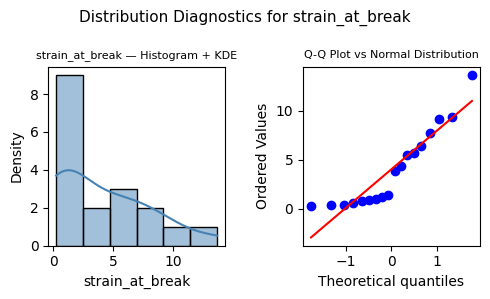

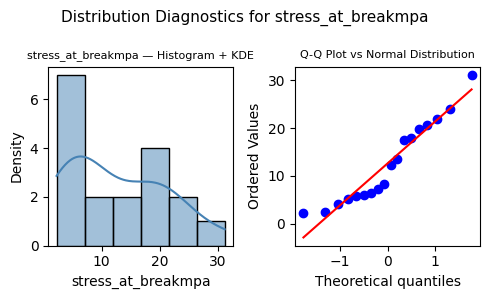

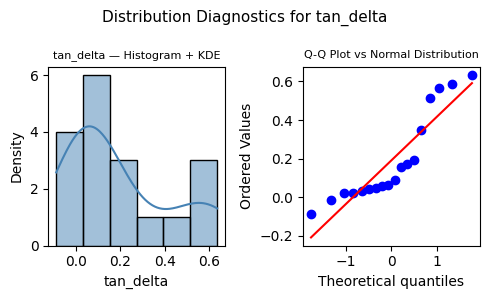

In [3]:
# plots for #2 - internet used for syntax set-up
import seaborn as sns                       #for histogram 
file_path = "Table 2_results.XLSX"                #how i saved the file
sheetname = "Lattice Plot"                 #sheet with repsonses for some reason

df = pd.read_excel(file_path, sheet_name=sheetname)
df.columns = [c.strip().lower().replace(" ", "_").replace("%", "pct")   #clean up columns
              .replace("(", "").replace(")", "") for c in df.columns]


responses = ['strain_at_break', 'stress_at_breakmpa', 'tan_delta'] #care about the output
cofactors = [c for c in df.columns if c not in responses]


X = df[cofactors].select_dtypes(include=[np.number]).fillna(df.mean())

#loop over each response to see its distribution
for resp in responses:
    y = df[resp].dropna().values            #remove any NaNs
    
    plt.figure(figsize=(5,3))              #new figure for this response
    
    #Histogram + Density line for smooth distribution
    plt.subplot(1,2,1)                      #left panel
    sns.histplot(y, bins='auto', kde=True, color='steelblue')  #histogram with density curve
    plt.title(f"{resp} — Histogram + KDE", fontsize=8)   
    plt.xlabel(resp)                         
    plt.ylabel("Density")                    
    
    #Q–Q Plot (Quantile–Quantile vs. Normal) 
    plt.subplot(1,2,2)                      #right panel 
    stats.probplot(y, dist="norm", plot=plt) #quantiles vs theoretical normal
    plt.title("Q-Q Plot vs Normal Distribution", fontsize=8)  
    
    #labeling
    plt.suptitle(f"Distribution Diagnostics for {resp}", fontsize=11)
    plt.tight_layout()                      # Adjust spacing between subplots
    plt.show()                              # Display the figure

## Question 3: Assess the dataset(s) for statistical relationships. Consider:

**Please perform data analysis for this question.**

   1. Are any of the data features cross-correlated (i.e., highly correlated)? Are any of them completely uncorrelated?

      I would assume some of the features are cross-correlated as chemical properties and strutures tend to be intertwined. Based on general chemical knowledge, we know that molecular weight and density are related (iso_mw & iso_density, and polyol_mw & polyol_density). The paper itself recognizes such interrelationships stating "spectral and cohesive energy descriptors are highly correlated through the polymer’s hydrogen-bonding network," implying they are aware of possible impacts. They use this to justify their choice of a hierarchical ML to handle the colinearities they expect. The statistical analysis shows that certain features have strong correlations (such as the ones listed above) while others have weak or nonexistent correlations.

   1. If the factor-response relationships are defined, what are the relationships between the factors and each response? Are any of them obvious/well-defined by 2D analyses?

      Based on the paper and figure 6, strain at break is credited as being mostly affected by CO wavenumber, NH absorbance per CO absorbance, cohesive energy density, and NH wavenumber, which is partially confirmed by the statistical analysis. Stress at break is said to be impacted by nh_w and NH absorbance per CO absorbance, but the statistical analysis reveals a higher impact from cohesive energy density and co_wavenumber. The 2D graphs plotted show relationships between these cofactors and responses, but you can clearly see how noisy they are with point spread out. The limited sampling probably impacted how accurate these relationships are too. Variables from Figure 6 were chosen for ease of paper comparison to see if their results could be found with independent analysis.

   1. Are higher dimensional relationships evident? (use a higher dimension visualization technique, in addition to low dimension techniques, to critically assess and probe these relationships).

      A 3D visualization shows a curved surface where strain increases as its top 3 important features change. This shows a non-linear relationship with interconnected features. Strain increases as cohesive energy density increases, but as CO Wavenumber lowers. More of these relationships are talked about in the "Results and Discussion" section of the paper.

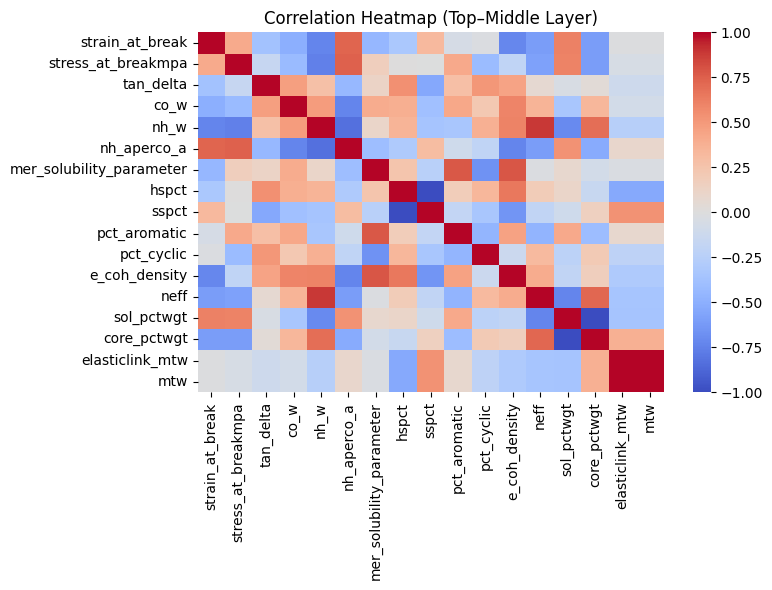


Top correlated features with strain_at_break:
nh_w            -0.732367
nh_aperco_a      0.731272
e_coh_density   -0.720269
sol_pctwgt       0.612297
neff            -0.607902
Name: strain_at_break, dtype: float64

Top correlated features with stress_at_breakmpa:
nh_w          -0.757444
nh_aperco_a    0.745970
core_pctwgt   -0.602890
sol_pctwgt     0.602766
neff          -0.578679
Name: stress_at_breakmpa, dtype: float64

Top correlated features with tan_delta:
hspct            0.540519
sspct           -0.540519
pct_cyclic       0.509101
co_w             0.469877
e_coh_density    0.451792
Name: tan_delta, dtype: float64


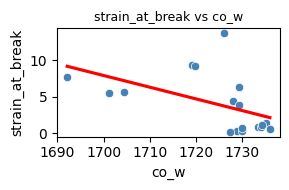

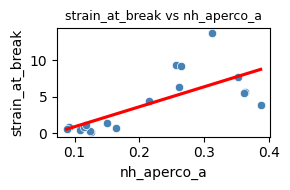

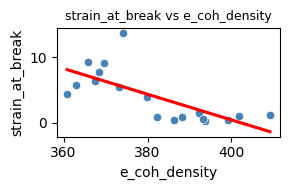

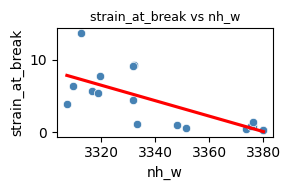

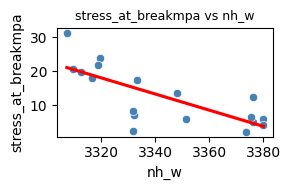

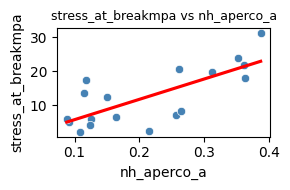

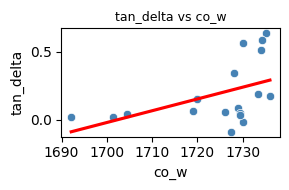

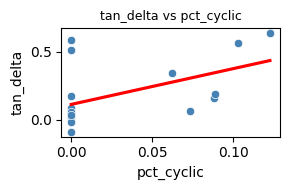

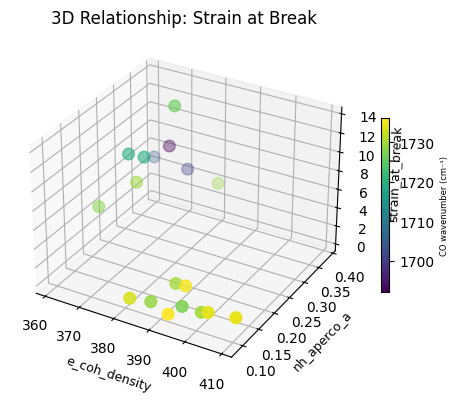

In [4]:
from mpl_toolkits.mplot3d import Axes3D   #3D plotting toolkit  -- internet used for syntax set-up

file_path = "Table 2_results.XLSX"                #how i saved the file
sheetname = "Top-Middle layer"                 #sheet with responses and cofactors

df = pd.read_excel(file_path, sheet_name=sheetname)
df.columns = [c.strip().lower().replace(" ", "_").replace("%", "pct")   #clean up columns
              .replace("(", "").replace(")", "") for c in df.columns]


responses = ['strain_at_break', 'stress_at_breakmpa', 'tan_delta'] #care about the output
cofactors = [c for c in df.columns if c not in responses]      

df_num = df.select_dtypes(include=[np.number]) #numerical columns only

#Part a - correlations
corr = df_num.corr(method='pearson') #pearson correlation coefficient

#Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap (Top–Middle Layer)")
plt.tight_layout()
plt.show()

#highlight the most important for each response
for resp in responses:
    print(f"\nTop correlated features with {resp}:")
    sorted_corr = corr[resp].drop(resp).sort_values(ascending=False, key=abs)
    print(sorted_corr.head(5))


#Part b - 2D - key pairs from figure 6 to ease comparing with paper
key_pairs = [
    ('co_w', 'strain_at_break'),
    ('nh_aperco_a', 'strain_at_break'),
    ('e_coh_density', 'strain_at_break'),
    ('nh_w', 'strain_at_break'),
    ('nh_w', 'stress_at_breakmpa'),
    ('nh_aperco_a', 'stress_at_breakmpa'),
    ('co_w', 'tan_delta'),
    ('pct_cyclic', 'tan_delta')
]

#relationships
for x, y in key_pairs:
    if x in df.columns and y in df.columns:
        plt.figure(figsize=(3,2))
        sns.scatterplot(x=df[x], y=df[y], color='steelblue')
        sns.regplot(x=df[x], y=df[y], scatter=False, color='red', ci=None)
        plt.title(f"{y} vs {x}",fontsize = 9)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.tight_layout()
        plt.show()

#part c - 3D
#ex strain at break & 3 key cofactors
X1, X2, X3 = 'e_coh_density', 'nh_aperco_a', 'co_w'
Y = 'strain_at_break'

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')

#Purple points = lower CO wavenumber = stronger hydrogen bonding
#Yellow points = higher CO wavenumber = weaker hydrogen bonding
sc = ax.scatter(df[X1], df[X2], df[Y], c=df[X3], cmap='viridis', s=70)
cb = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=20)         #yeah I can't figure out how to move this sorry I tried
cb.set_label('CO wavenumber (cm⁻¹)', fontsize = 6)
ax.set_xlabel(X1,fontsize = 9)
ax.set_ylabel(X2, fontsize = 9)
ax.set_zlabel(Y, fontsize = 9)
ax.set_title("3D Relationship: Strain at Break")
plt.tight_layout()
plt.show()



## Question 4: Develop process model(s) to pursue considering the answers for 1-3. 
Homework students will compare their own assessment with the authors work and choice of process models. Project students will develop their own process models to take forward in their projects. Consider:

   1. What is the technical/statistical purpose of each process model (screening, prediction, etc.)? What are the engineering goals/aims of the impacts of the process model(s)? What advancement to the state of the art will be made and/or what problems will be solved that weren't solved before? 

      Hierarchical Model is used to find relationships between specific chemical features and physical mechanical properties. Within that, the paper uses Gaussian-Process Regression is used to predict parameters that are not explicitly measured (labelled as cofactors in this case).

      The engineering goals and aims are to be able to predict mechanical properties of polyurethane elastomers. 

      Advancements to the state of the art would be to handle non-linear or multi-collinear data. Additionally, it could predict spectroscopic, thermodynamic, and mechanical properties based on polymer composition. 

   1. What are the factors, cofactors, and responses for each model? How do the answers from 1-3 motivate these choices (or if assessing authors work, do their datasets support their choices)?

      For the HML overall, the factors, cofactors, and responses are listed in question 1. The factors and repsonses of the Gaussian regression would be the factors and cofactors listed in Question 1, respectively. Collinearities and intertwined data inherent to the complexity of chemical structures implies that predictions could benefit from the use of a machine learning model.

      Question 1 mainly provides scalar and continuous data that is used to predict a middle layer. Question 2 shows that the data is overdispersed, and non-normal, requiring a Gaussian or Bayesian methods that do not require normal residuals. Question 3 demonstrates that there are certain relationships between certain chemical features and mechanical properties. 